In [1]:
%pylab inline
import os
import gc
import scipy
import numpy as np
import catutil as utilities
import imgSimutil as imgUtil
import astropy.io.fits as pyfits
from astropy.table import Table,vstack,hstack

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim/

/lustre/work/xiangchong.li/work/FPFS2/sim


In [18]:
www=False
zbound  =   np.array([0.,0.561,0.906,1.374,5.410])
nz=len(zbound)-1
bAll=[]
for psz in ['45','60','75']:
    out=[]
    for xx in ['0000','2222']:
        dataAll=[]
        for pixId in imgUtil.cosmoHSThpix[:-1]:
            data= pyfits.getdata('outCosmo-var36em4/src-psf%s-%d/stackAll-g1-%s_2.fits' %(psz,pixId,xx))
            dataAll.append(data[data['wlmask']])
            del data
            gc.collect()
        dataAll=np.hstack(dataAll)
        #del msk
        e1,e2=utilities.get_gal_ellip(dataAll)
        if www:
            weight  =   dataAll['i_hsmshaperegauss_derived_weight']
        else:
            weight  =   np.ones(len(dataAll))
        #dataAll['i_hsmshaperegauss_derived_rms_e']=0.365
        ooo=np.zeros(nz)
        for iz in range(nz):
            #msk=utilities.get_snr(dataAll)<30.
            msk=(dataAll['zphot']>zbound[iz])&(dataAll['zphot']<zbound[iz+1])
            w_A     =   np.sum(weight[msk])
            #Res_A   =   1.-np.sum(dataAll['i_hsmshaperegauss_derived_rms_e'][msk]**2.*weight[msk])/w_A
            ooo[iz] =   np.sum(weight[msk]*e1[msk])/w_A
            del msk
        out.append(ooo)
        del e1,e2,weight,w_A,ooo
        gc.collect()

    response1=(out[1]-out[0])/0.04

    pList=['2000','0200','0020','0002']
    outZd=np.zeros(nz)
    for iz in range(4):
        xx=pList[iz]
        dataAll=[]
        for pixId in imgUtil.cosmoHSThpix[:-1]:
            data= pyfits.getdata('outCosmo-var36em4/src-psf%s-%d/stackAll-g1-%s_2.fits' %(psz,pixId,xx))
            dataAll.append(data[data['wlmask']])
            del data
            gc.collect()
        dataAll=np.hstack(dataAll)
        #del msk
        e1,e2=utilities.get_gal_ellip(dataAll)
        if www:
            weight  =   dataAll['i_hsmshaperegauss_derived_weight']
        else:
            weight  =   np.ones(len(dataAll))
        #dataAll['i_hsmshaperegauss_derived_rms_e']=0.365
        msk=(dataAll['zphot']>zbound[iz])&(dataAll['zphot']<zbound[iz+1])
        w_A     =   np.sum(weight[msk])
        outZd[iz]=np.sum(weight[msk]*e1[msk])/w_A
        del msk

    response2=(outZd-out[0])/0.04
    bias=response2/response1-1
    bAll.append(bias)

In [37]:
np.sqrt(1-response2/2.)

array([0.3404947 , 0.34000278, 0.34251299, 0.39272814])

In [19]:
print(bAll)

[array([-7.60867408e-05, -4.76873535e-04, -7.32587330e-05,  2.97795564e-04]), array([-3.77331447e-05, -4.22631866e-04, -8.17585495e-04, -7.95351481e-04]), array([-0.00022273, -0.00048845, -0.00105539, -0.00189647])]


(-0.3, 0.1)

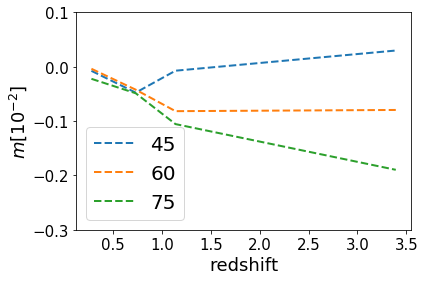

In [38]:
lList=['45','60','75']
for i in range(3):
    plt.plot((zbound[:-1]+zbound[1:])/2.,bAll[i]*100,'--',label=lList[i])
plt.legend(loc='lower left')
plt.ylabel(r'$m [10^{-2}]$')
plt.xlabel('redshift')
plt.ylim(-0.3,0.1)